<a href="https://colab.research.google.com/github/xyvivian/RCA/blob/master/BayesSiren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, combinations
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import collections
from copy import deepcopy
from scipy.stats import norm
import seaborn as sns

In [13]:

from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def normal_func(sensor):
    def normal_S1(x):
        return np.sin(x)
    def normal_S2(x):
        return np.cos(x)

    def normal_S3(x):
        return np.cos(1.1*x)

    if sensor == "S1":
        return normal_S1

    if sensor == "S2":
        return normal_S2

    if sensor == "S3":
        return normal_S3


def error_func(err,theta):
    def error1(x):
        return theta* np.sin(x)
    def error2(x):
        return theta* np.cos(x)
    def error3(x):
        return theta* np.sin(10*x)
    def error4(x):
        return theta* np.cos(5*x)

    if err == "Error1":
        return error1
    if err == "Error2":
        return error2
    if err == "Error3":
        return error3
    if err == "Error4":
        return error4


def composite_err_func(err_list, theta_list, time_frame):
    err_val = []
    for err,theta in zip(err_list,theta_list):
         err_val.append(error_func(err,theta)(time_frame))
    return np.sum(err_val, axis=0)



class BN():
    def __init__(self, sensor_list, errors, prior_distributions, sigmas):
        # sensor_list: how many sensors
        # errors: the errors associated with the sensors,
        # SHOULD BE {"S1": tuple[ERROR1, ERROR2, ..], "S2": tuple[ERROR1,ERROR2..]}
        # prior_distribution: expert's guess on the distributions SHOULD BE {"Error1": -1COS(5T),...}
        # sigmas: variances of gaussian
        # sensor_error_list: experts' guesses with the sensors
        # thetas: updated parameters
        # stored_data: the data stored with the particular error
        self.sensor_list = sensor_list
        self.errors = errors
        self.sensor_size = len(self.sensor_list)
        self.sigmas = sigmas
        self.sensor_error_list = []
        self.thetas = {}
        for sensor in sensor_list:
            self.thetas[sensor] = {}
        self.stored_data = {}
        self.errors_list = {}
        self.errors_name_list = {}
        self.prior_distributions = prior_distributions


    def error_generation(self,error_list, error_name_list):
        error_combination_list = list((powerset(error_list)))[1:]
        error_name_combination_list = list((powerset(error_name_list)))[1:]

        # Get all linear combinations of the experts' guess
        error_result_list = []
        for err in error_combination_list:
            err_arr = np.array(err)
            if err_arr.shape[0] > 1:
                err_arr = np.sum(err_arr, axis=0)
            if err_arr.shape[0] == 1:
                err_arr = err_arr.reshape((err_arr.shape[1],))
            error_result_list.append(err_arr)

        return error_result_list, error_name_combination_list


    def create_error_lists(self,time_frame):
        #"S1","S2","S3"... {Error1, }
        for sensor, error in self.errors.items():
            err_list = []
            for single_err in error:
                err_list.append(self.prior_distributions[single_err](time_frame))
            err_list, err_name = self.error_generation(err_list, list(error))
            err_list.insert(0, normal_func(sensor)(time_frame))
            err_name.insert(0, ())
            self.errors_list[sensor] = err_list
            self.errors_name_list[sensor] = err_name

    def error_calculation(self,error_list, theta, x):
        err_val = []
        for err in error_list:
            err_val.append(error_func(err,theta)(x))
        return np.sum(err_val, axis=0)


    def get_max(self,my_list):
        import operator
        index, value = max(enumerate(my_list), key=operator.itemgetter(1))
        return index,value


    def find_most_probable_error(self,err_names, probs):
        ind, prob = self.get_max(probs)
        print(ind, prob)
        print(err_names[ind])
        return err_names[ind], prob


    def search_helper(self, err_prefix, err_name_prefix, errors, error_names):
        if sorted(err_prefix.keys()) == sorted(self.errors_list.keys()):
            errors.append(deepcopy(err_prefix))
            error_names.append(deepcopy(err_name_prefix))
            return
        else:
            visited_sensors = list(err_prefix.keys())
            total_sensors = list(self.errors_list.keys())
            remained_sensors = np.setdiff1d(total_sensors, visited_sensors)
            targeted_sensors = remained_sensors[0]

            for i in range(len(self.errors_list[targeted_sensors])):
                err_prefix[targeted_sensors] = self.errors_list[targeted_sensors][i]
                err_name_prefix[targeted_sensors] = self.errors_name_list[targeted_sensors][i]

                self.search_helper(err_prefix,err_name_prefix,errors,error_names)
                err_prefix.pop(targeted_sensors, self.errors_list[targeted_sensors][i])
                err_name_prefix.pop(targeted_sensors,self.errors_name_list[targeted_sensors][i])



    def check_conflicts(self, errors, error_names):
        ret_err = []
        ret_err_name = []
        inv_err = collections.defaultdict(set)
        for k, v in self.errors.items():
            for item in v:
                inv_err[item].add(k)

        for i in range(len(error_names)):
            candidate = error_names[i]
            checked_error = set()
            wrong_config = False
            for sensor,error in candidate.items():
                for err in error:
                    if err in checked_error:
                        break
                    checked_error.add(err)
                    required_indices = list(inv_err[err])
                    wrong_config = any([ err not in candidate[i] for i in required_indices])
                    if wrong_config:
                        break
                if wrong_config:
                    break
            if not wrong_config:
                ret_err.append(errors[i])
                ret_err_name.append(error_names[i])
        return ret_err, ret_err_name



    # Baysian Calculation)
    # P(S2=y2|E3= 0,E4= 0)·P(S1=y1|E1= 1,E2= 0,E3= 0)· 1/ 16
    # Assuming each error occurs equally (so P(E1= 1)P(E2= 0)P(E3= 0)P(E4= 0) can be ignored )
    def bayesian_calculation_update(self, sensor_inputs,time_frame):
        self.create_error_lists(time_frame)
        err_names = []
        probs = []
        errors = []
        error_names = []
        self.search_helper({}, {}, errors, error_names)
        # need to make sure all the lists do not have conflicts
        errors, error_names = self.check_conflicts(errors, error_names)
        for i in range(len(errors)):
            err_name = tuple(set([item for sublist in error_names[i].values() for item in sublist]))
            err_val = errors[i]
            for key, value in self.thetas.items():
                if err_name in value.keys():
                    data_size = self.stored_data[err_name][1][key].shape[0]
                    theta_prime = self.thetas[key][err_name]
                    val = self.error_calculation(error_names[i][key], theta_prime, time_frame)
                    err_val[key] = (1 - 1 / np.log(data_size)) * val + (1 / np.log(data_size)) * err_val[key]

            prob = 0.0
            for j in self.sensor_list:
                for i in range(len(sensor_inputs[j])):
                    gaussian_err = norm.pdf(sensor_inputs[j][i], loc=err_val[j][i], scale=self.sigmas[j])
                    prob += np.log(gaussian_err)

            err_names.append(err_name)
            probs.append(prob)

        error, pro = self.find_most_probable_error(err_names, probs)
        return error, pro, (err_names, probs)



    # Train a new MLE that better fits the data
    def update(self, time_frame, sensor_inputs,errors):
        self.update_data_map(time_frame,sensor_inputs,errors)
        #list of empty tuples
        error_list = {}
        for s in self.sensor_list:
            error_list[s] = (tuple())

        for err in errors:
            for key, value in self.errors.items():
                if err in value:
                    error_list[key] = error_list[key] + (err,)
        for sensor_key,err_value in error_list.items():
            theta_prime = 0.0
            if err_value != ():
                theta_prime = self.MLE_update(sensor_key,err_value, errors)
            if theta_prime != 0.0:
                self.thetas[sensor_key][errors] = theta_prime


    # update data_map
    def update_data_map(self,time_frame,sensor_inputs,error):
        if error in self.stored_data:
            old_time_frame = self.stored_data[error][0]
            old_sensors = self.stored_data[error][1]

            updated_time_frame = np.hstack((old_time_frame, time_frame))
            updated_sensor_inputs = deepcopy(sensor_inputs)
            for key,_ in updated_sensor_inputs.items():
                updated_sensor_inputs[key] = np.hstack((old_sensors[key], sensor_inputs[key]))

            self.stored_data[error] = (updated_time_frame, updated_sensor_inputs)
        else:
            self.stored_data[error] = (time_frame, sensor_inputs)

    #MLE_update calculation
    def MLE_update(self,sensor_key, err_value, errors):
        y = []
        re_x, re_list = self.stored_data[errors]
        for err in err_value:
            y.append(error_func(err, 1)(re_x))
        y = np.sum(np.array(y), axis=0)
        theta_prime = np.mean(np.divide(re_list[sensor_key], y, out=np.zeros_like(re_list[sensor_key]), where=y != 0))
        return theta_prime


In [14]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

In [15]:
!pip install gplearn
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state

In [16]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [17]:
class Signal_Data(torch.utils.data.Dataset):
    def __init__(self, ts, inout):
        self.data = inout
        self.data = self.data.astype(np.float32)
        self.timepoints = get_mgrid(len(self.data), 1)

    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        amplitude = self.data
        scale = np.max(np.abs(amplitude))
        amplitude = (amplitude / scale)
        amplitude = torch.Tensor(amplitude).view(-1, 1)
        return self.timepoints, amplitude

In [18]:
def train_siren(dataloader):
  signal_siren = Siren(in_features=1, out_features=1, hidden_features=256, 
                    hidden_layers=3, first_omega_0=3000, outermost_linear=True)
  signal_siren.cuda()

  total_steps = 500
  steps_til_summary = 200

  optim = torch.optim.Adam(lr=1e-4, params=signal_siren.parameters())

  model_input, ground_truth = next(iter(dataloader))
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

  for step in range(total_steps):
      model_output, coords = signal_siren(model_input)    
      loss = F.mse_loss(model_output, ground_truth)
      
      if not step % steps_til_summary:
          print("Step %d, Total loss %0.6f" % (step, loss))
      
          fig, axes = plt.subplots(1,2)
          axes[0].plot(coords.squeeze().detach().cpu().numpy(),model_output.squeeze().detach().cpu().numpy())
          axes[1].plot(coords.squeeze().detach().cpu().numpy(),ground_truth.squeeze().detach().cpu().numpy())
          plt.show()

      optim.zero_grad()
      loss.backward()
      optim.step()

  return signal_siren

In [19]:
def run_sirens(ts, sirens, siren_count, sysout, err_thres):
  cur_count = 0
  syserr = sysout
  while(cur_count < siren_count):
    sysval, coords = sirens[cur_count]['Model'](ts)
    syserr = syserr - sysval
    
    print("Current System Error", torch.mean(torch.abs(syserr)))
    err_vals = sirens[cur_count]['Model_Preds']
    
    print("Error Threshold", (np.mean(err_vals) + 1*np.std(err_vals)))
    if torch.mean(torch.abs(syserr)).cpu().detach().numpy() > (np.mean(err_vals) + 1*np.std(err_vals)):
      cur_count += 1
    else:
      return syserr, cur_count
    print("Count", cur_count, "Sirens", siren_count)
  return syserr, cur_count

In [20]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

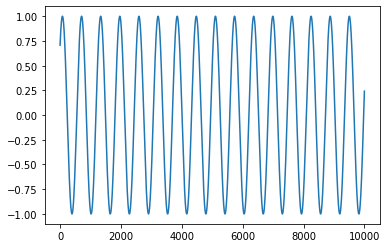

In [21]:
ts = np.arange(10000)/100
noise = 0.1
sysout = np.sin(ts) + np.cos(ts)
nor_signal = Signal_Data(ts, sysout)
dataloader_signal = DataLoader(nor_signal, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)
plt.plot(nor_signal[0][1])

In [ ]:
#fit a SIREN predictor to the normal data
model_input, ground_truth = next(iter(dataloader_signal))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

sirens.append({"Model": train_siren(dataloader_signal), 'Model_Preds': []})